# Notebook with various expirement with XGBoost

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, roc_auc_score, roc_curve, mean_absolute_error
from IPython.display import display
import random
import shap

from util import make_study_df, \
    plot_shap_feature_importance, plot_xgb_feature_importance, plot_shap_importance_with_summary, \
    plot_shap_summary, plot_shap_heatmap, plot_shap_dependence, top_shap_values

#### supress sklearn warnings (hopefully)

In [4]:
import os
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [5]:
! python --version

Python 3.11.6


In [6]:
print('xgboost version', xgb.__version__)
print('sklearn version', sklearn.__version__)
print('shap version', shap.__version__)

xgboost version 1.7.6
sklearn version 1.3.0
shap version 0.42.1


## load miRNA data

In [7]:
miRNA_df = pd.read_excel('../data/transposed_Tf_miRNA.xlsx')

## create dataframes and X, y datasets

In [8]:
df_all_weeks = make_study_df(miRNA_df)
df_8_weeks = make_study_df(miRNA_df, cohort_str='8_weeks')
df_16_weeks = make_study_df(miRNA_df, cohort_str='16_weeks')

In [9]:
X_all_weeks, y_all_weeks = df_all_weeks.drop('infected', axis=1), df_all_weeks['infected']
X_8_weeks, y_8_weeks = df_8_weeks.drop('infected', axis=1), df_8_weeks['infected']
X_16_weeks, y_16_weeks = df_16_weeks.drop('infected', axis=1), df_16_weeks['infected']

In [10]:
df_8_weeks.head()

,miR-362-3p,miR-743b-3p,miR-412,miR-542-3p,miR-92a,miR-181a,miR-9,miR-130a,miR-329,miR-23b,...,miR-1892,miR-1967,miR-542-5p,miR-367,miR-m107-1-5p,miR-448,miR-188-3p,miR-140,miR-802,miR-2137
9,73,23,116,87,28,10183,217,737,101,3433,...,146,161,185,161,122,134,21,198,45,173
12,65,36,82,58,27,3898,100,651,91,1138,...,76,100,103,96,97,80,27,181,38,67
2,107,24,71,48,27,7079,233,840,151,2333,...,36,108,122,76,75,72,20,190,38,82
13,71,25,72,42,10,4125,92,705,76,1387,...,69,73,99,75,74,76,19,172,26,75
17,150,24,100,83,31,3746,776,1166,120,2486,...,152,153,160,118,117,129,21,318,40,111


### compute XGBoost models

In [9]:
params = {
    "random_state": 42,
    "objective":"binary:logistic",
    "colsample_bytree": 0.3, 
    "learning_rate": 0.1,
}   

In [10]:
model_all_weeks = xgb.XGBClassifier(**params).fit(X_all_weeks, y_all_weeks)
model_8_weeks = xgb.XGBClassifier(**params).fit(X_8_weeks, y_8_weeks)
model_16_weeks = xgb.XGBClassifier(**params).fit(X_16_weeks, y_16_weeks)

### compute SHAP values (used for explainablity)

In [11]:
# need to change int and bool to classes int_ and bool_ to handle error 'numpy' has no attribute 'int'/'bool'/etc.
np.bool = np.bool_
np.int = np.int_
np.float = np.float_

In [12]:
explainer_all_weeks = shap.TreeExplainer(model_all_weeks, X_all_weeks, feature_names=X_all_weeks.columns.tolist())
shap_values_all_weeks = explainer_all_weeks(X_all_weeks)

explainer_8_weeks = shap.TreeExplainer(model_8_weeks, X_8_weeks, feature_names=X_8_weeks.columns.tolist())
shap_values_8_weeks = explainer_8_weeks(X_8_weeks)

explainer_16_weeks = shap.TreeExplainer(model_16_weeks, X_16_weeks, feature_names=X_16_weeks.columns.tolist())
shap_values_16_weeks = explainer_16_weeks(X_16_weeks)

## bar plots for feature importance

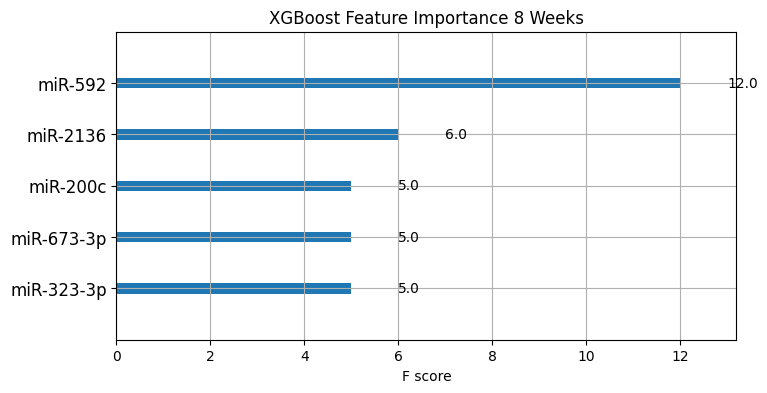

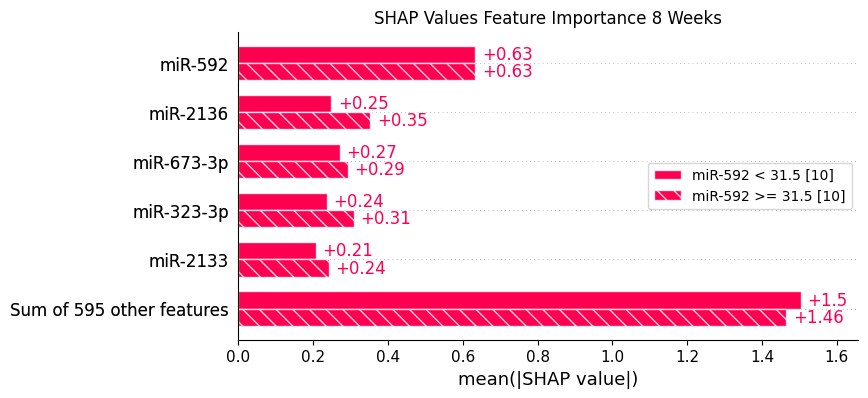

In [13]:
plot_xgb_feature_importance(
    model_8_weeks, 'XGBoost Feature Importance 8 Weeks', save_fig=False)
plot_shap_feature_importance(
    shap_values_8_weeks, 'SHAP Values Feature Importance 8 Weeks', save_fig=False)
# plot_shap_summary(
#     shap_values_8_weeks, X_8_weeks, 'SHAP Values Feature Importance 8 Weeks', plot_type='bar', save_fig=False)

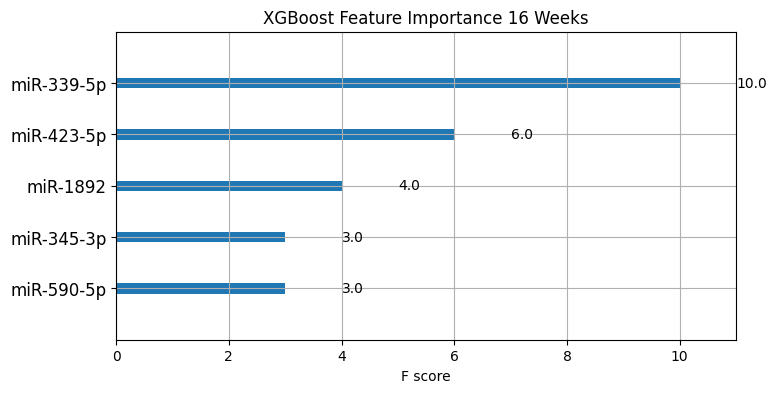

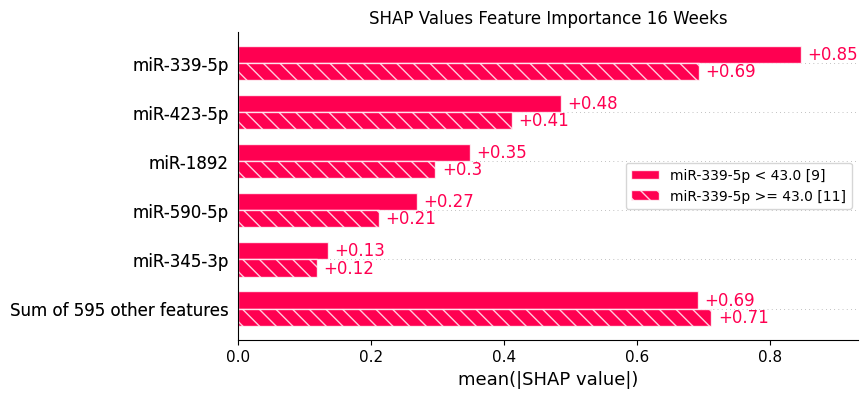

In [14]:
plot_xgb_feature_importance(
    model_16_weeks, 'XGBoost Feature Importance 16 Weeks', save_fig=False)
plot_shap_feature_importance(
    shap_values_16_weeks, 'SHAP Values Feature Importance 16 Weeks', save_fig=False)

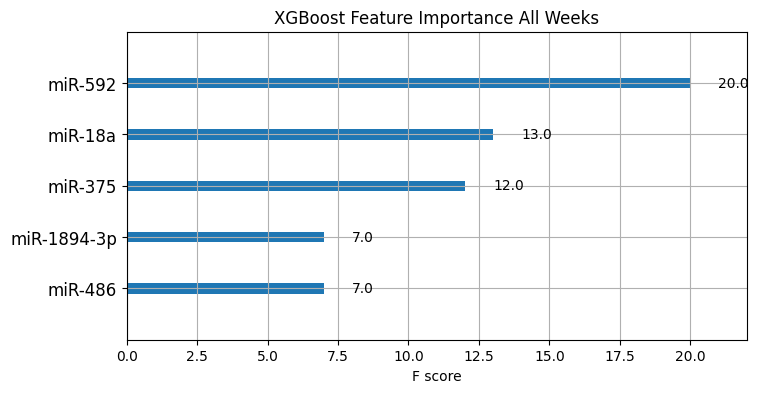

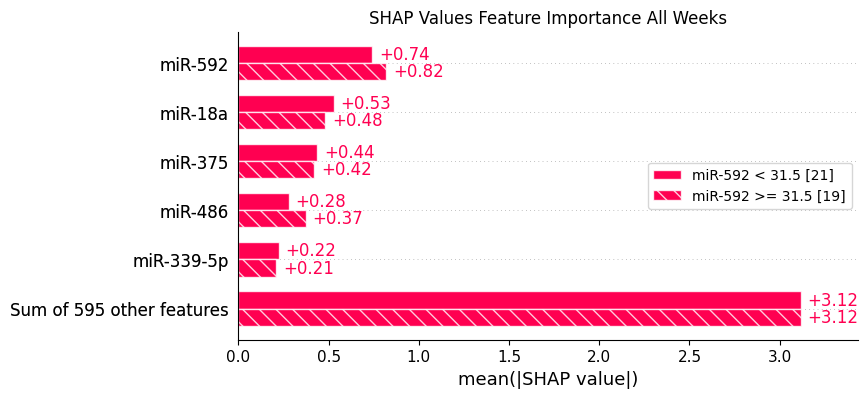

In [15]:
plot_xgb_feature_importance(
    model_all_weeks, 'XGBoost Feature Importance All Weeks', save_fig=False)
plot_shap_feature_importance(
    shap_values_all_weeks, 'SHAP Values Feature Importance All Weeks', save_fig=False)

## SHAP summary plots

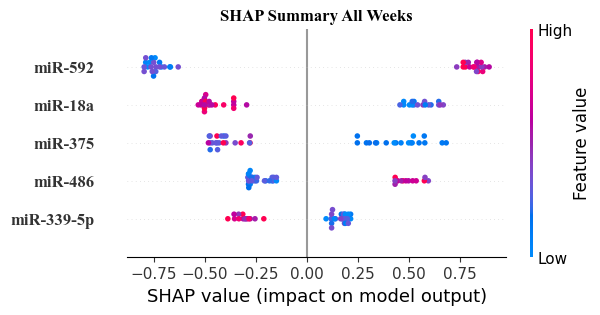

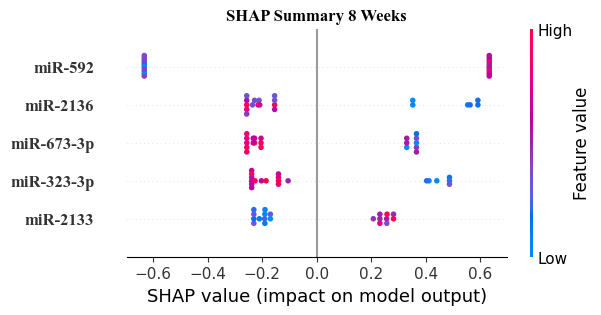

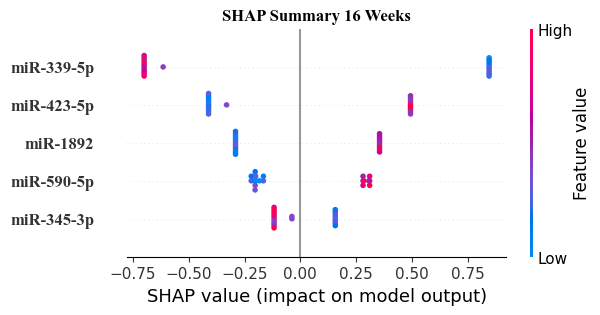

In [16]:
plot_shap_summary(shap_values_all_weeks, X_all_weeks, "SHAP Summary All Weeks", save_fig=False)
plot_shap_summary(shap_values_8_weeks, X_8_weeks, "SHAP Summary 8 Weeks", save_fig=False)
plot_shap_summary(shap_values_16_weeks, X_16_weeks, "SHAP Summary 16 Weeks", save_fig=False)

## SHAP heatmaps

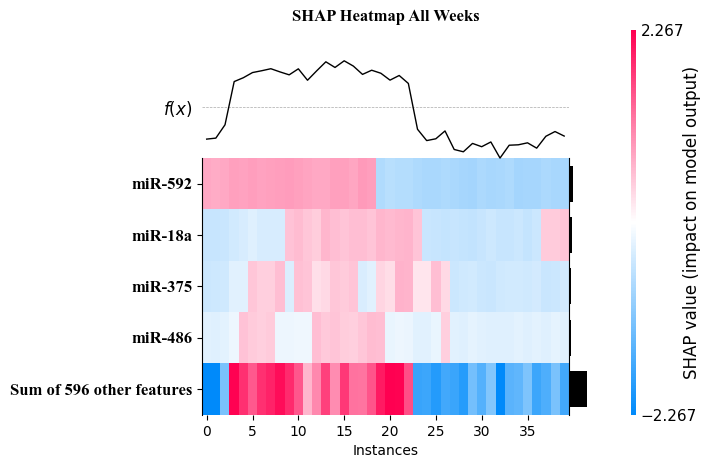

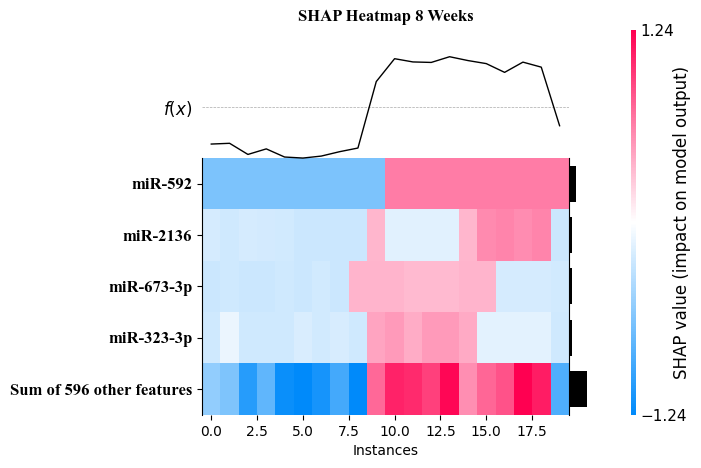

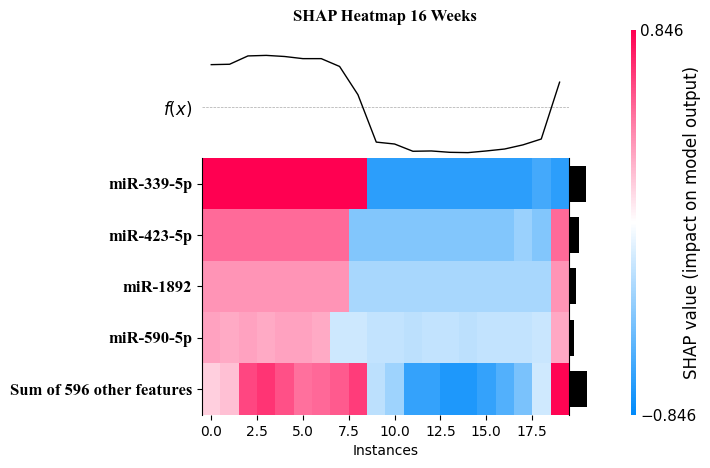

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [17]:
plot_shap_heatmap(shap_values_all_weeks, "SHAP Heatmap All Weeks", save_fig=False)
plot_shap_heatmap(shap_values_8_weeks, "SHAP Heatmap 8 Weeks", save_fig=False)
plot_shap_heatmap(shap_values_16_weeks, "SHAP Heatmap 16 Weeks", save_fig=False)

## SHAP dependence plots

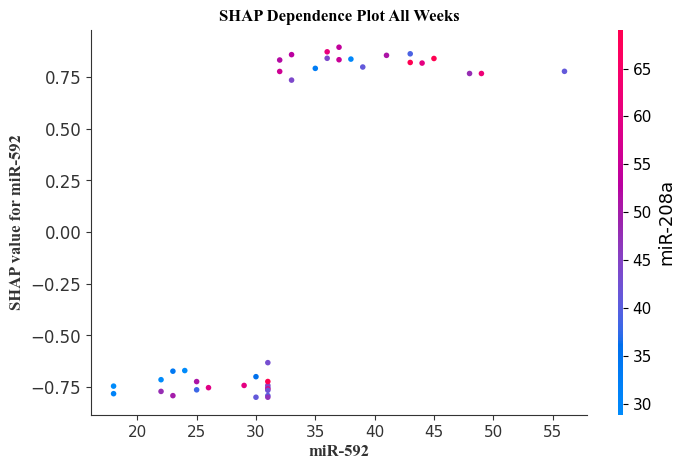

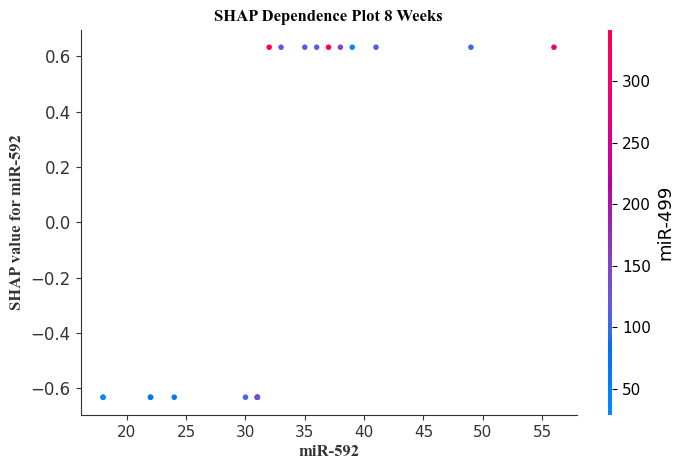

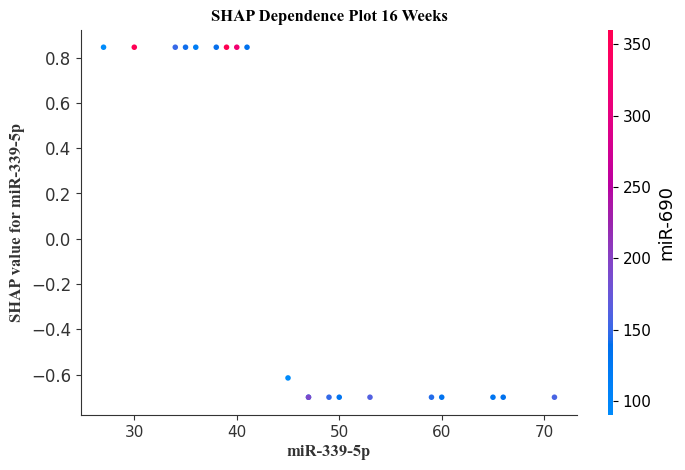

In [18]:
plot_shap_dependence(shap_values_all_weeks, X_all_weeks, "SHAP Dependence Plot All Weeks", save_fig=False)
plot_shap_dependence(shap_values_8_weeks, X_8_weeks, "SHAP Dependence Plot 8 Weeks", save_fig=False)
plot_shap_dependence(shap_values_16_weeks, X_16_weeks, "SHAP Dependence Plot 16 Weeks", save_fig=False)

---

## experiment with grid search for best params

In [19]:
cv_params = {
    'n_estimators': range(1,300),              # default = 100
    'max_depth': range(1, 100),                 # default = 3
    'learning_rate': [.1, .3, .4, .5, .6],     # default = .3
    'colsample_bytree': [.6, .7, .8, .9, 1],   # default = 1,
    'booster':['gbtree']
}

In [20]:
grid_search = GridSearchCV(xgb.XGBRegressor(), cv_params, n_jobs=10, scoring='neg_mean_absolute_error', refit=True)

In [21]:
# # this takes around 1 day to run, so saving the results
# grid_search.fit(X_8_weeks, y_8_weeks)
# grid_search.best_params_

# # results
# {'booster': 'gbtree',
#  'colsample_bytree': 0.7,
#  'learning_rate': 0.1,
#  'max_depth': 2,
#  'n_estimators': 1}

In [22]:
grid_params = {
    'booster': 'gbtree',
    'colsample_bytree': 0.7,
    'learning_rate': 0.1,
    'max_depth': 2,
    'n_estimators': 1
}
model_grid_all = xgb.XGBClassifier(**grid_params).fit(X_all_weeks, y_all_weeks)
model_grid_8 = xgb.XGBClassifier(**grid_params).fit(X_8_weeks, y_8_weeks)
model_grid_16 = xgb.XGBClassifier(**grid_params).fit(X_16_weeks, y_16_weeks)

In [23]:
explainer_grid_all = shap.TreeExplainer(model_grid_all, X_all_weeks, feature_names=X_all_weeks.columns.tolist())
shap_values_grid_all = explainer_grid_all(X_all_weeks)

explainer_grid_8 = shap.TreeExplainer(model_grid_8, X_8_weeks, feature_names=X_8_weeks.columns.tolist())
shap_values_grid_8 = explainer_grid_8(X_8_weeks)

explainer_grid_16 = shap.TreeExplainer(model_grid_16, X_16_weeks, feature_names=X_16_weeks.columns.tolist())
shap_values_grid_16 = explainer_grid_16(X_16_weeks)

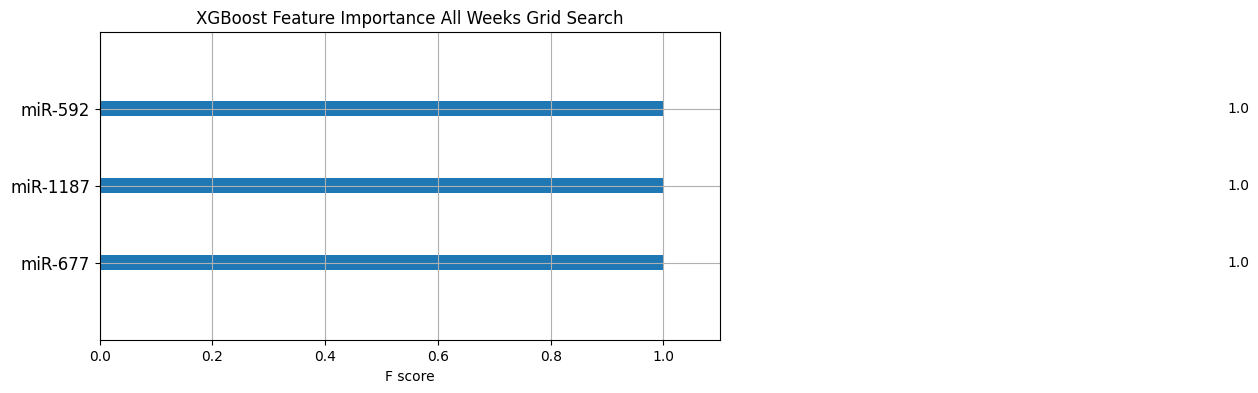

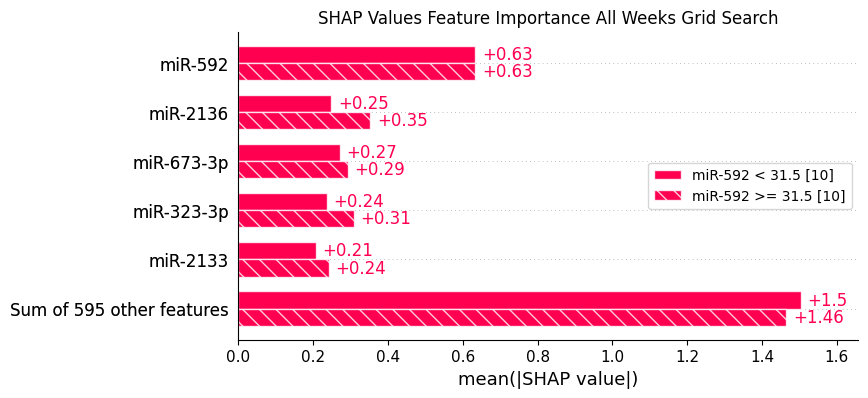

In [24]:
plot_xgb_feature_importance(model_grid_all, 'XGBoost Feature Importance All Weeks Grid Search', save_fig=False)
plot_shap_feature_importance(shap_values_8_weeks, 'SHAP Values Feature Importance All Weeks Grid Search', save_fig=False)

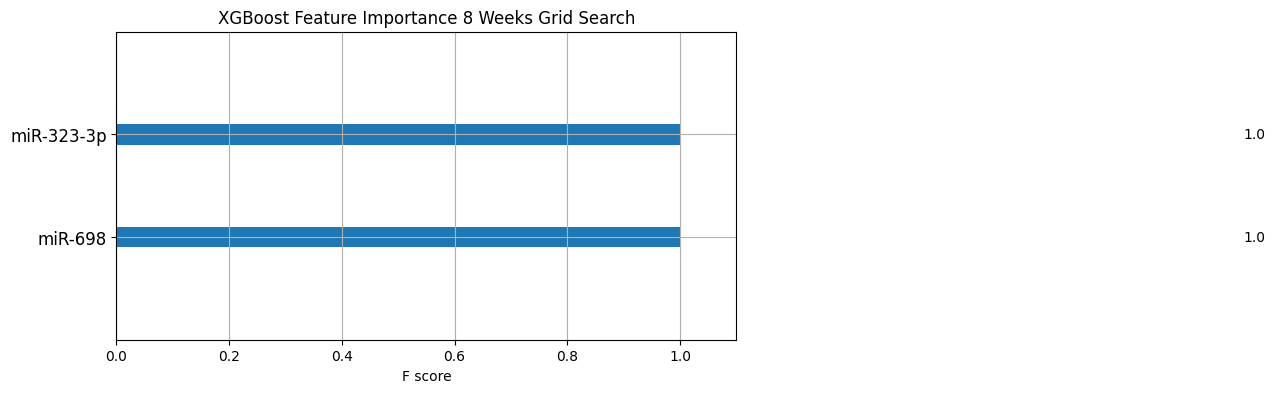

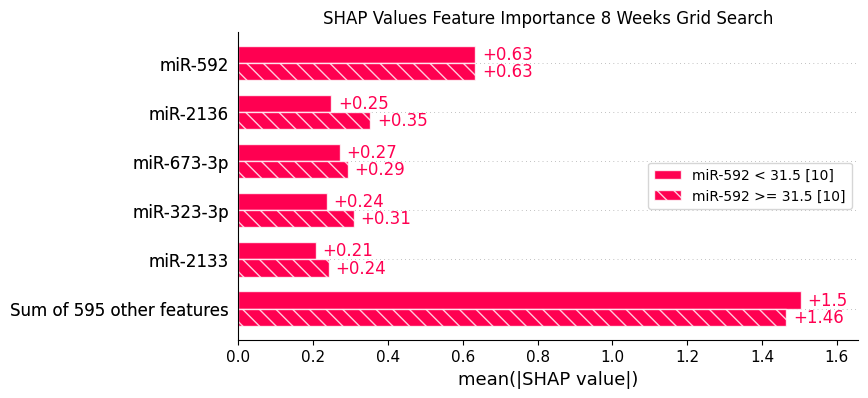

In [25]:
plot_xgb_feature_importance(model_grid_8, 'XGBoost Feature Importance 8 Weeks Grid Search', save_fig=False)
plot_shap_feature_importance(shap_values_8_weeks, 'SHAP Values Feature Importance 8 Weeks Grid Search', save_fig=False)

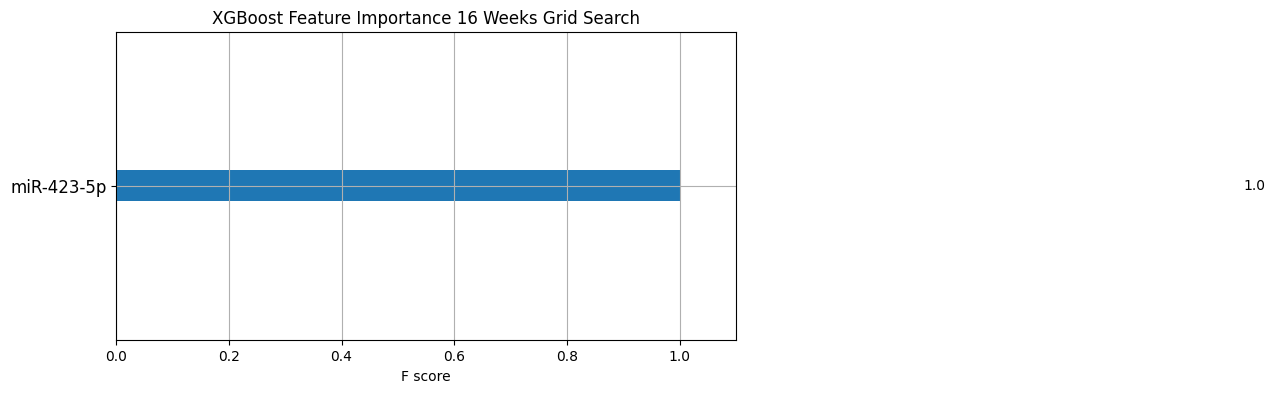

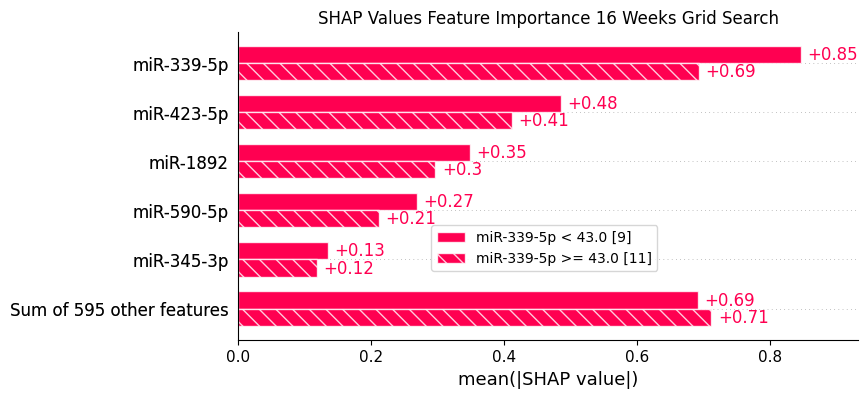

In [26]:
plot_xgb_feature_importance(model_grid_16, 'XGBoost Feature Importance 16 Weeks Grid Search', save_fig=False)
plot_shap_feature_importance(
    shap_values_16_weeks, 
    'SHAP Values Feature Importance 16 Weeks Grid Search',
    legend_loc='lower left',
    bbox_values=(0.3, 0.2),
    save_fig=False
)

----

### expirment with increased extimators and tree depth

In [27]:
increased_params = {
    'booster': 'gbtree',
    'colsample_bytree': 0.7,
    'learning_rate': 0.1,
    'max_depth': 600,
    'n_estimators': 600,
    'random_state': 42
}
model_increased_all = xgb.XGBClassifier(**increased_params).fit(X_all_weeks, y_all_weeks)
model_increased_8 = xgb.XGBClassifier(**increased_params).fit(X_8_weeks, y_8_weeks)
model_increased_16 = xgb.XGBClassifier(**increased_params).fit(X_16_weeks, y_16_weeks)

In [28]:
explainer_increased_all = shap.TreeExplainer(model_increased_all, X_all_weeks, feature_names=X_all_weeks.columns.tolist())
shap_values_increased_all = explainer_increased_all(X_all_weeks)

explainer_increased_8 = shap.TreeExplainer(model_increased_8, X_8_weeks, feature_names=X_8_weeks.columns.tolist())
shap_values_increased_8 = explainer_increased_8(X_8_weeks)

explainer_increased_16 = shap.TreeExplainer(model_increased_16, X_16_weeks, feature_names=X_16_weeks.columns.tolist())
shap_values_increased_16 = explainer_increased_16(X_16_weeks)

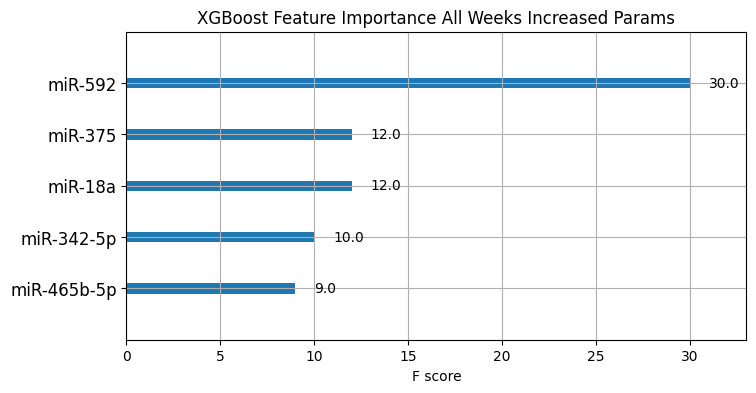

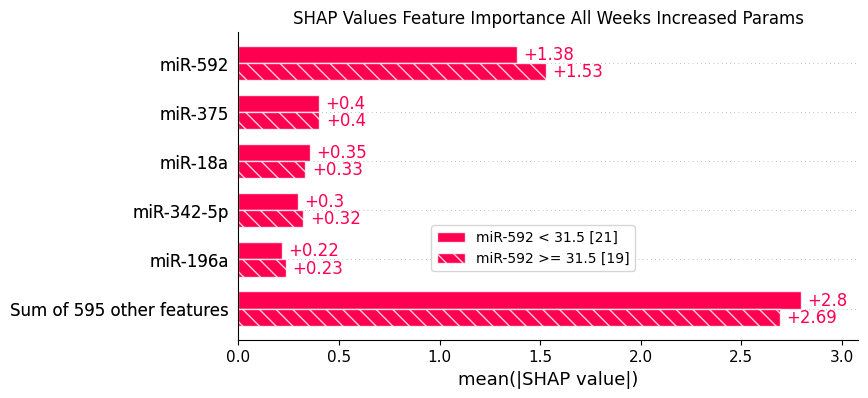

In [29]:
plot_xgb_feature_importance(model_increased_all, 'XGBoost Feature Importance All Weeks Increased Params', save_fig=False)
plot_shap_feature_importance(
    shap_values_increased_all, 
    'SHAP Values Feature Importance All Weeks Increased Params',
    legend_loc='lower left',
    bbox_values=(0.3, 0.2),
    save_fig=False
)

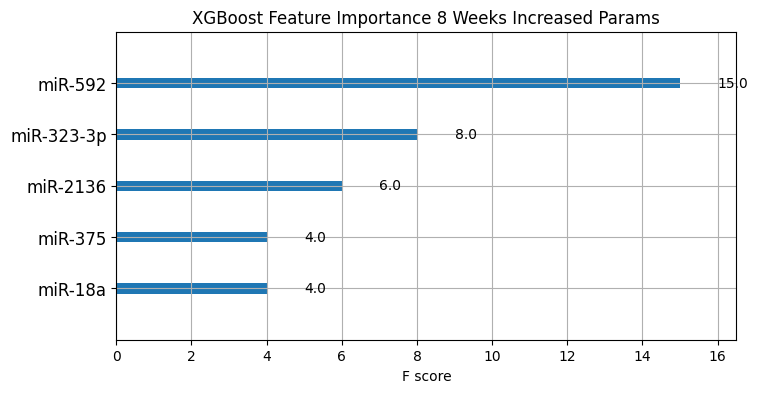

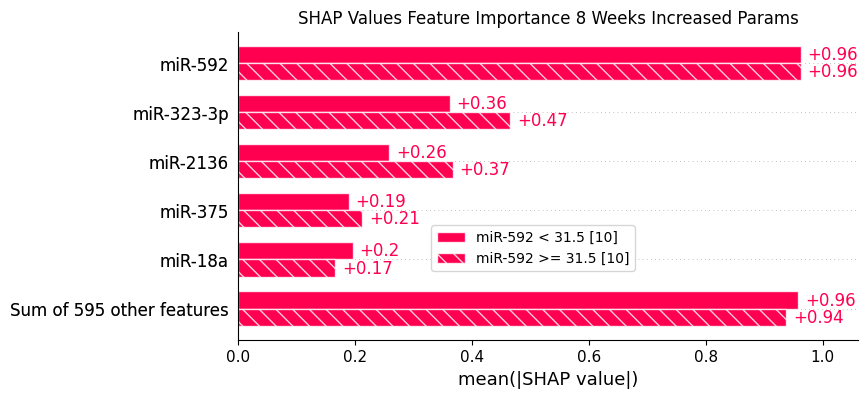

In [30]:
plot_xgb_feature_importance(model_increased_8, 'XGBoost Feature Importance 8 Weeks Increased Params', save_fig=False)
plot_shap_feature_importance(
    shap_values_increased_8, 
    'SHAP Values Feature Importance 8 Weeks Increased Params',
    legend_loc='lower left',
    bbox_values=(0.3, 0.2),
    save_fig=False
)

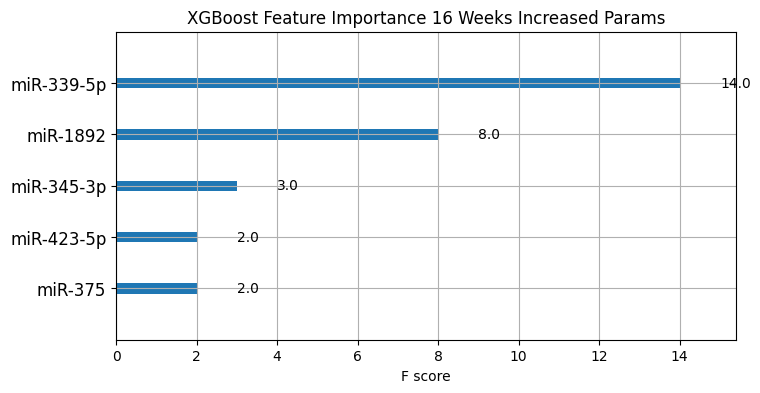

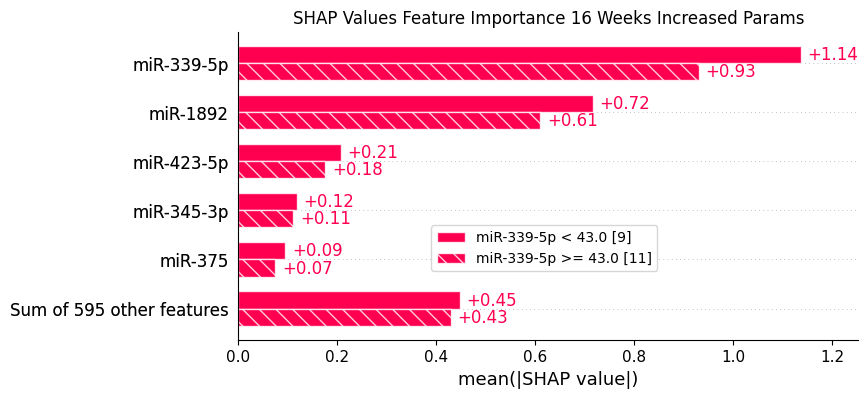

In [31]:
plot_xgb_feature_importance(model_increased_16, 'XGBoost Feature Importance 16 Weeks Increased Params', save_fig=False)
plot_shap_feature_importance(
    shap_values_increased_16, 
    'SHAP Values Feature Importance 16 Weeks Increased Params',
    legend_loc='lower left',
    bbox_values=(0.3, 0.2),
    save_fig=False
)

---

## experiment with VIF

In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [33]:
vif_df = pd.DataFrame()
vif_df["feature"] = X_8_weeks.columns
vif_df["VIF"] = [variance_inflation_factor(X_8_weeks.values, i) for i in range(len(X_8_weeks.columns))]

In [34]:
len(X_8_weeks.columns) == X_8_weeks.shape[1]

True

In [35]:
vif_df.head()

,feature,VIF
0,miR-499,inf
1,miR-2134,inf
2,miR-669i,inf
3,miR-3470a+mmu-miR-3470b,inf
4,miR-207,inf


## expirement with recursive feature elemination

In [36]:
from sklearn.feature_selection import RFECV, RFE

In [37]:
params = {
    "random_state": 42,
    "objective":"binary:logistic",
    "colsample_bytree": 0.3, 
    "learning_rate": 0.1,
    #"nfold": 5,
    #"num_boost_round": 100, 
    #"early_stopping_rounds": 10, 
    #"metrics": "auc"
}   

In [38]:
selector_all = RFECV(xgb.XGBClassifier(**params), cv=5, min_features_to_select=100, scoring='accuracy')
selector_8 = RFECV(xgb.XGBClassifier(**params), cv=5, min_features_to_select=100, scoring='accuracy')
selector_16 = RFECV(xgb.XGBClassifier(**params), cv=5, min_features_to_select=100, scoring='accuracy')

In [39]:
selector_all = selector_all.fit(X_all_weeks, y_all_weeks)
selector_8 = selector_8.fit(X_8_weeks, y_8_weeks)
selector_16 = selector_16.fit(X_8_weeks, y_16_weeks)

In [40]:
selected_all_cols = list(selector_all.feature_names_in_[selector_all.support_])
X_all_selected = X_all_weeks[selected_all_cols]

selected_8_cols = list(selector_8.feature_names_in_[selector_8.support_])
X_8_selected = X_8_weeks[selected_8_cols]

selected_16_cols = list(selector_16.feature_names_in_[selector_16.support_])
X_16_selected = X_16_weeks[selected_16_cols]

In [41]:
model_selected_all = xgb.XGBClassifier(**params).fit(X_all_selected, y_all_weeks)
model_selected_8 = xgb.XGBClassifier(**params).fit(X_8_selected, y_8_weeks)
model_selected_16 = xgb.XGBClassifier(**params).fit(X_16_selected, y_16_weeks)

In [42]:
explainer_selected_all = shap.TreeExplainer(model_selected_all, X_all_selected, feature_names=X_all_selected.columns.tolist())
shap_values_selected_all = explainer_selected_all(X_all_selected)

explainer_selected_8 = shap.TreeExplainer(model_selected_8, X_8_selected, feature_names=X_8_selected.columns.tolist())
shap_values_selected_8 = explainer_selected_8(X_8_selected)

explainer_selected_16 = shap.TreeExplainer(model_selected_16, X_16_selected, feature_names=X_16_selected.columns.tolist())
shap_values_selected_16 = explainer_selected_16(X_16_selected)

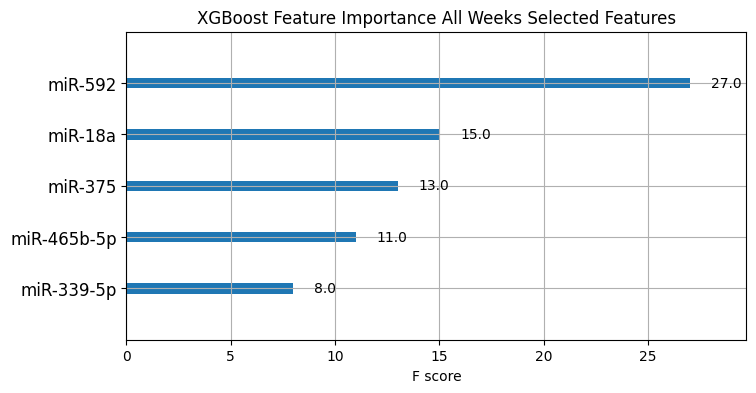

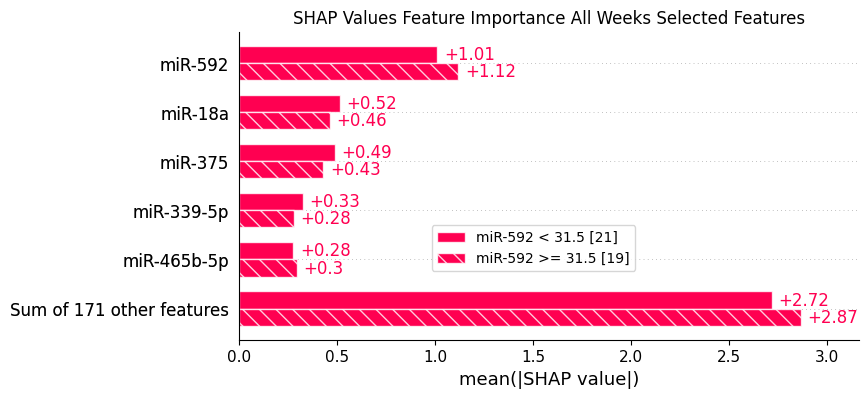

In [43]:
plot_xgb_feature_importance(model_selected_all, 'XGBoost Feature Importance All Weeks Selected Features', save_fig=False)
plot_shap_feature_importance(
    shap_values_selected_all, 
    'SHAP Values Feature Importance All Weeks Selected Features',
    legend_loc='lower left',
    bbox_values=(0.3, 0.2),
    save_fig=False
)

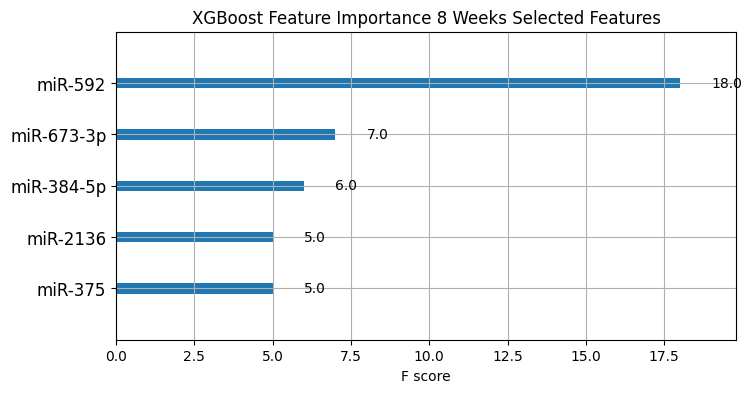

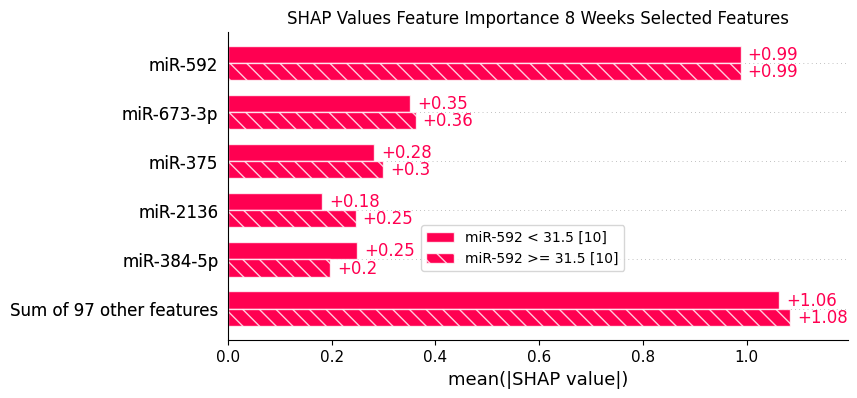

In [44]:
plot_xgb_feature_importance(model_selected_8, 'XGBoost Feature Importance 8 Weeks Selected Features', save_fig=False)
plot_shap_feature_importance(
    shap_values_selected_8, 
    'SHAP Values Feature Importance 8 Weeks Selected Features',
    legend_loc='lower left',
    bbox_values=(0.3, 0.2),
    save_fig=False
)

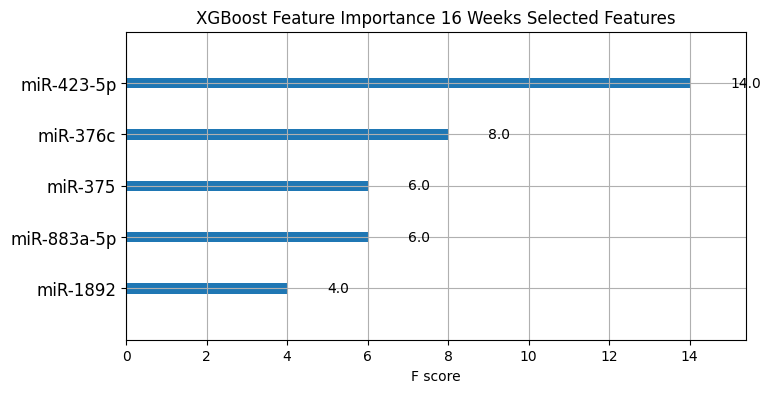

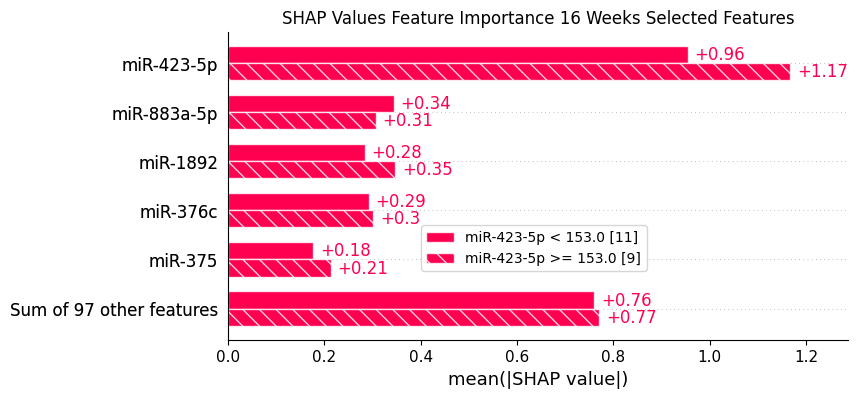

In [45]:
plot_xgb_feature_importance(model_selected_16, 'XGBoost Feature Importance 16 Weeks Selected Features', save_fig=False)
plot_shap_feature_importance(
    shap_values_selected_16, 
    'SHAP Values Feature Importance 16 Weeks Selected Features',
    legend_loc='lower left',
    bbox_values=(0.3, 0.2),
    save_fig=False
)

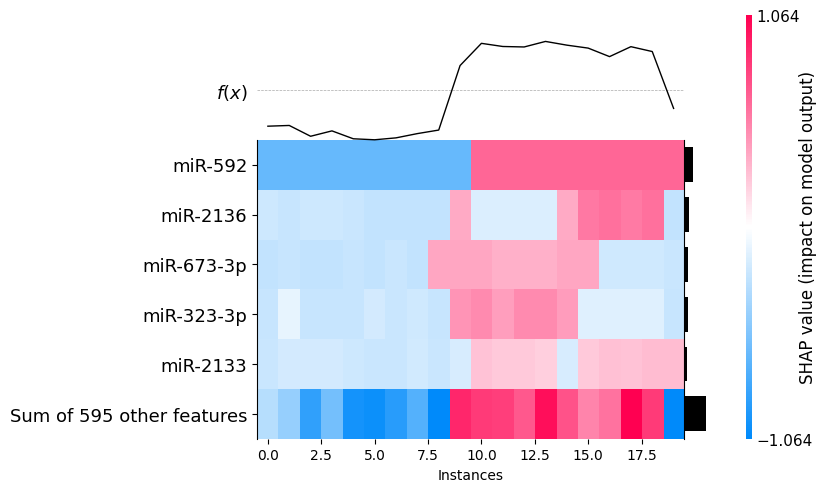

        feature  shap_val
11      miR-592  0.633085
515    miR-2136  0.300403
285  miR-673-3p  0.282050
89   miR-323-3p  0.271688
353    miR-2133  0.223741


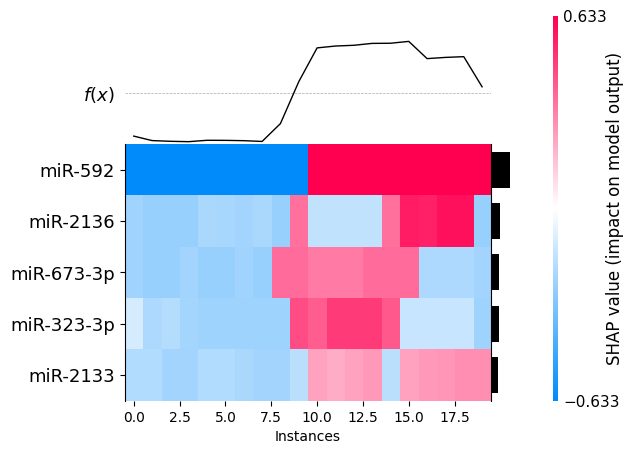

In [46]:
shap.plots.heatmap(shap_values_8_weeks, max_display=6)
shap.plots.heatmap(top_shap_values(shap_values_8_weeks, print_importance=True))

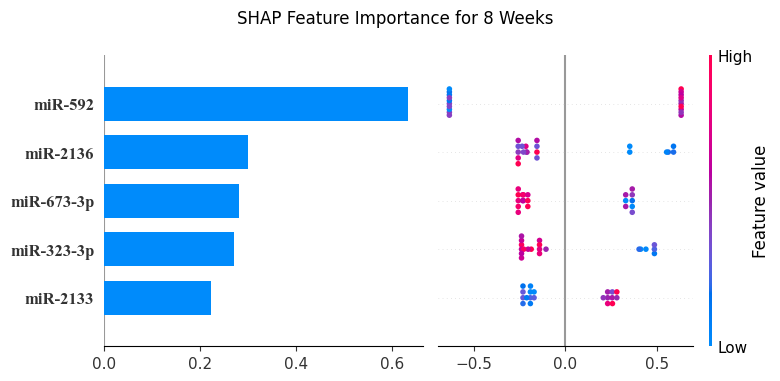

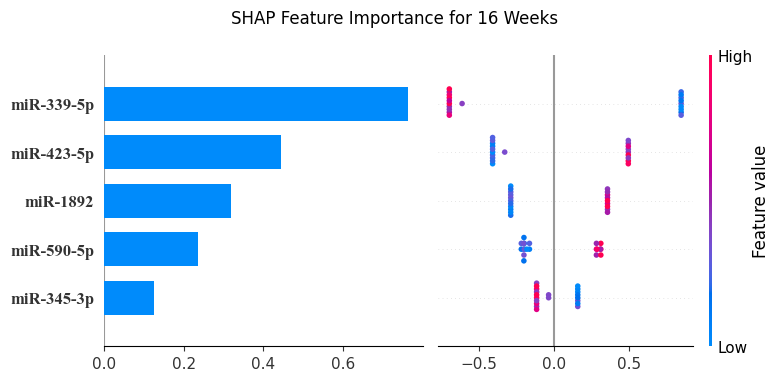

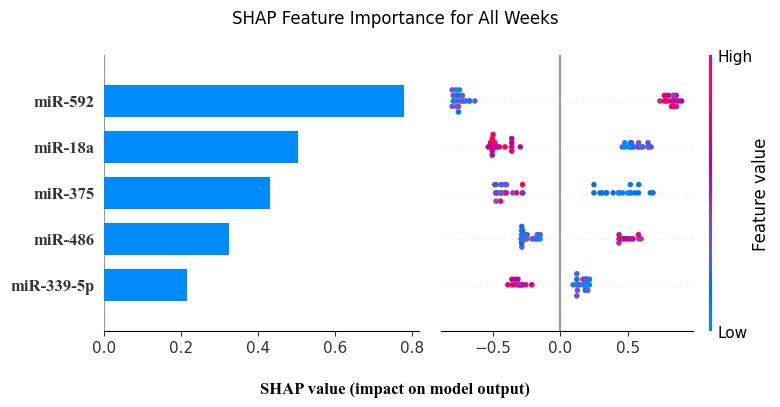

In [47]:
plot_shap_importance_with_summary(
    shap_values_8_weeks, 
    X_8_weeks, 
    title='SHAP Feature Importance for 8 Weeks',
    save_fig=False
)

plot_shap_importance_with_summary(
    shap_values_16_weeks, 
    X_16_weeks, 
    title='SHAP Feature Importance for 16 Weeks',
    save_fig=False
)

plot_shap_importance_with_summary(
    shap_values_all_weeks, 
    X_all_weeks, 
    title='SHAP Feature Importance for All Weeks',
    supxlabel = 'SHAP value (impact on model output)',
    save_fig=False
)

---

## expirment with Kfold CV

In [58]:
from sklearn.model_selection import \
    LeaveOneOut, cross_val_score, cross_val_predict, cross_validate
from util import param_search, param_search_cv

In [75]:
# see https://medium.com/grabngoinfo/hyperparameter-tuning-for-xgboost-91449869c57e
# see https://medium.com/@rithpansanga/the-main-parameters-in-xgboost-and-their-effects-on-model-performance-4f9833cac7c
# n_estimators: Number of trees in random forest
# max_depth: Maximum number of levels in tree
# tree_method: Tree construction algorithm used in XGBoost
# colsample_bytree: Percentage of columns to be randomly samples for each tree.
# eta: Learning rate
# gamma: Minimum loss reduction required to make further partition
# reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
# reg_lambda provides l2 regularization to the weight, higher values result in more conservative models

random_grid = {
    "objective": ["binary:logistic"],
    "n_estimators": list(range(25, 1001, 25)), # [25, 50, 75, ... 1000],
    "booster": ["gbtree", "dart", None],
    "learning_rate": [0.1, 0.3, 0.5, 0.7, 0.9, 1],
    "gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
    'max_depth': list(range(10, 201, 10)) + [None],# [10, 20, 30, ... 200, None],
    "colsample_bytree": [i/10.0 for i in range(3,10)],
    # "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100], # not searching
    # "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100], # not seqarching
    'random_state': list(range(0, 9, 10)) # [0, 3, 6, 9]
}

In [91]:
# used for testing single param search
params_8_weeks = \
    param_search(random_grid, X_8_weeks, y_8_weeks, xgb.XGBClassifier, cv=10)

{'booster': 'gbtree',
 'colsample_bytree': 0.9,
 'gamma': 0.3,
 'learning_rate': 1,
 'max_depth': None,
 'n_estimators': 100,
 'objective': 'binary:logistic',
 'random_state': 0}


In [109]:
test = {
 'booster': 'gbtree',
 'colsample_bytree': 0.9,
 'gamma': 0.3,
 'learning_rate': 1,
 'max_depth': None,
 'n_estimators': 100,
 'objective': 'binary:logistic',
 'random_state': 0
}
m = xgb.XGBClassifier(**test).fit(X_8_weeks, y_8_weeks)
sc = np.mean(cross_val_score(m, X_8_weeks, y_8_weeks, cv=LeaveOneOut()))
sc

0.65

In [106]:
accuracy_score(m.predict(X_8_weeks), y_8_weeks)

1.0

In [71]:
cv_range = range(2, 11)
clf = xgb.XGBClassifier

params_8_weeks_cv = \
    param_search_cv(
        random_grid, X_8_weeks, y_8_weeks, clf, cvs=cv_range, print_iter=False, print_scores=True)

KeyboardInterrupt: 